## 1.0 Introduction
The solution we are planning to explore in this notebook is which genres and platforms are best to go for development for a game development company.

### 1.a Loading the Data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('Video_Game_Sales_as_of_Jan_2017.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76.0,51.0,8.0,324.0,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82.0,73.0,8.3,712.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80.0,73.0,8.0,193.0,E
4,Pokemon Red/Pokemon Blue,G,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN


In [2]:
data.shape

(17416, 15)

### 1.b Cleaning the Data
As the data set stands, it needs a little bit of cleaning before it can be analyzed. First, video games with unknown release years should be omitted. Furthermore, the video games released in 2017 will also be omitted since the data was gathered in January and the sales of those video games have not yet reached full potential. Finally, pandas is reading the years as floating points, to create nice plots the years should be changed to integers.

In [3]:
# Remove NaN data from Year of Release
data = data[data['Year_of_Release'].notnull()]

# Omitting video games released in 2017.
data = data.loc[data['Year_of_Release'] < 2017]

# Converting year of release to integers
data['Year_of_Release'] = data['Year_of_Release'].astype(int)

### 1.c Determining Usable Years
Considering the video game sales before a certain point in time would not only be irrelevant for predicting sales in the close future but could skew the predictions. To determine the starting year two things should be considered: the yearly global sales and at what point in time were all genres being continuously released. Fortunately, a starting year can be chosen by looking at the total yearly global sales, the cumulative proportion of yearly global sales and the heat map of global sales of games release each year by genre. Using these three plots below it can be seen that all genres are not fully represented until 1991 and more than 95% of the global sales occur after 1991. Hence we will start by only considering the video game sales from 1991 to 2016.

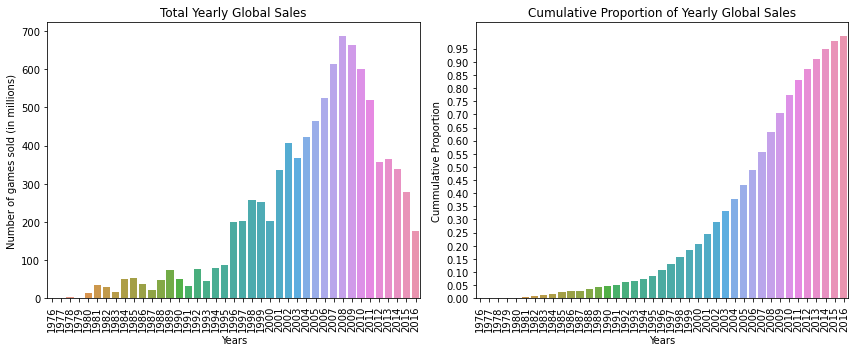

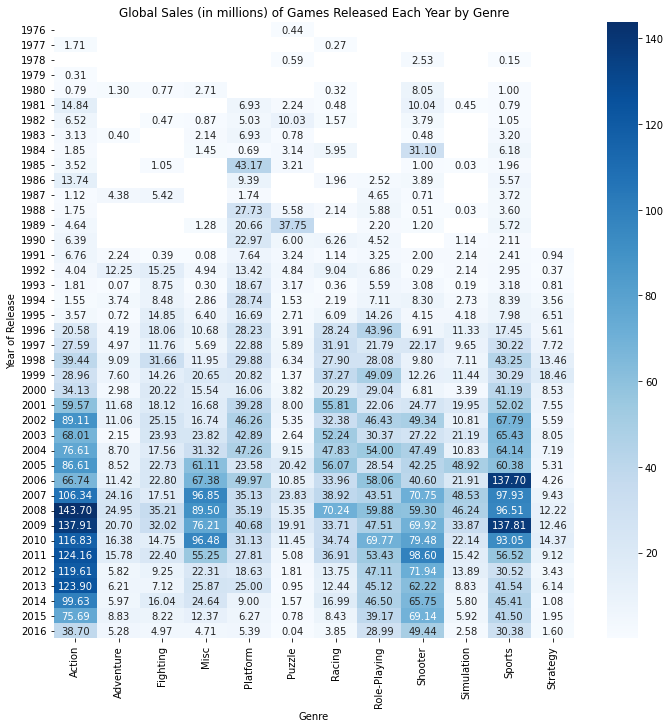

In [4]:
# Creating a table of the total global sales for each genre and year
Sales_by_Genre_and_Year = pd.pivot_table(data, index=['Year_of_Release'], columns=['Genre'], values=['Global_Sales'], aggfunc=np.sum)
Sales_by_Genre_and_Year.columns = Sales_by_Genre_and_Year.columns.get_level_values(1)

# Finding the yearly totals and cumulative proportion of yearly global sales
Yearly_Totals = Sales_by_Genre_and_Year.sum(axis=1)
Yearly_Totals = Yearly_Totals.sort_index()
YT1_cumsum = Yearly_Totals.cumsum() / Yearly_Totals.sum()

# Plotting the yearly totals and cumulative proportions
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.barplot(y = Yearly_Totals.values, x = Yearly_Totals.index,ax=ax1)
ax1.set_title('Total Yearly Global Sales')
plt.setp(ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of games sold (in millions)')

sns.barplot(y = YT1_cumsum.values, x = YT1_cumsum.index, ax=ax2)
ax2.set_title('Cumulative Proportion of Yearly Global Sales')
plt.setp(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('Years')
ax2.set_ylabel('Cummulative Proportion')
ax2.yaxis.set_ticks(np.arange(0,1,0.05))
fig.tight_layout()

# Plotting the heat map of global sales for games released each year by genre
plt.figure(figsize=(10,10))
sns.heatmap(Sales_by_Genre_and_Year, annot = True, fmt = '.2f', cmap = 'Blues')
plt.tight_layout()
plt.ylabel('Year of Release')
plt.xlabel('Genre')
plt.title('Global Sales (in millions) of Games Released Each Year by Genre')
plt.show()

### 1.d Creating the Data Set to Analyze
With the selection of years now comes the choice of how to represent the yearly global sales for each genre. Since the total number of games released each year varies, the total global sales for each genre would not be a consistent measure over time. Furthermore, by plotting a histogram of the global sales it is easy to see the data is highly skewed to the right, meaning the yearly average of the global sales for each genre will not be an acceptable measure. For highly skewed data, the median is an acceptable measure, so we will consider the median number of games sold per genre each year.

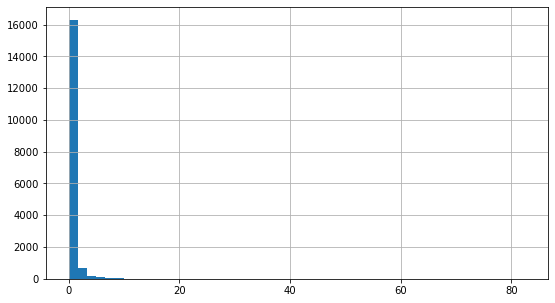

In [5]:
# Histogram of global sales
plt.figure(figsize=(9,5))
data.Global_Sales.hist(bins=50)
plt.show()

In [6]:
# Pulling only the data from 1991 to 2016
data = data.loc[data.Year_of_Release >= 1991]

# Finding the median sales value by genre and year
Med_Sales_by_Genre_and_Year = pd.pivot_table(data, index=['Year_of_Release'], columns=['Genre'], values=['Global_Sales'], aggfunc=np.median)
Med_Sales_by_Genre_and_Year.columns = Med_Sales_by_Genre_and_Year.columns.get_level_values(1)

Med_Sales_by_Genre_and_Year.head(10)

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_of_Release,,,,,,,,,,,,
1991,0.420,1.120,0.390,0.080,0.780,0.585,1.140,0.380,0.230,1.070,0.280,0.215
1992,2.020,0.475,1.660,2.470,1.000,1.120,4.520,0.970,0.130,2.140,0.370,0.060
1993,0.145,0.070,0.450,0.060,0.560,0.980,0.180,0.320,1.540,0.190,0.180,0.405
1994,0.050,0.435,0.180,0.050,1.790,0.700,0.190,0.120,0.330,0.280,0.345,0.310
1995,0.380,0.050,0.230,0.085,0.300,0.175,0.155,0.340,0.100,0.085,0.190,0.125
1996,0.245,0.150,0.180,0.180,0.340,0.150,0.765,0.260,0.190,0.270,0.210,0.195
1997,0.240,0.140,0.250,0.235,0.360,0.260,0.290,0.400,0.130,0.320,0.490,0.235
1998,0.250,0.115,0.250,0.310,0.470,0.220,0.310,0.275,0.120,0.825,0.450,0.090
1999,0.400,0.140,0.155,0.400,0.465,0.040,0.300,0.450,0.300,0.325,0.315,0.200


## 2.0 Analyzing the Data Set
Simple linear regression can be used to explore basic increasing/decreasing trends.

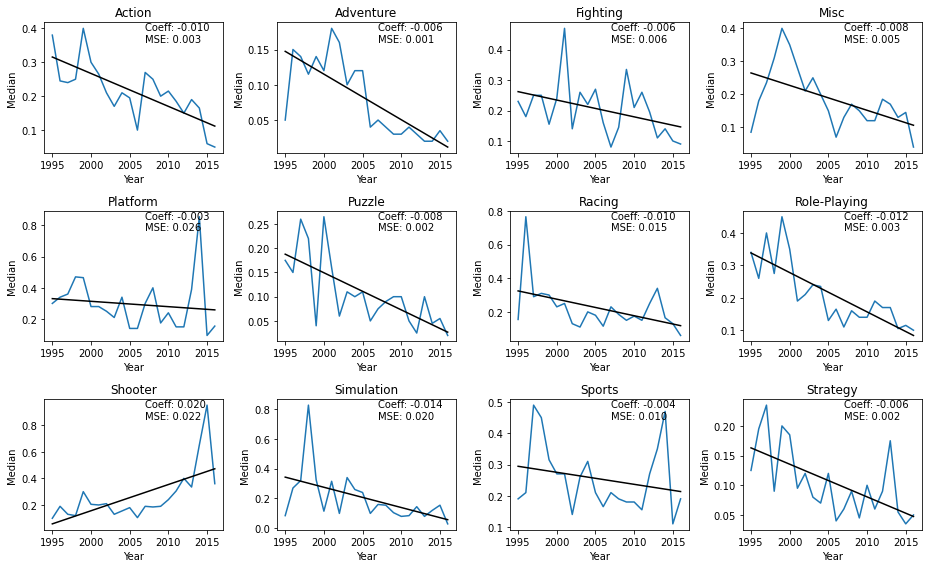

In [13]:
def LinearRegressionPlot(Data):
    RegrCoeff = []
    RegrMSE = []
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13,8))
    X_data = np.transpose(np.matrix(Data.index))
    cnt = 0
    
    for genre in Data.columns:
        axis = axes[cnt//4, cnt%4]
        y_data = Data[genre].to_frame()
    
        # Linear regression
        regr = linear_model.LinearRegression()
        regr.fit(X_data, y_data)
        
        # Mean Squared Error
        MSE = np.mean((regr.predict(X_data)-y_data)**2)
        RegrCoeff.append(regr.coef_[0][0])
        RegrMSE.append(MSE[0])

        Data[genre].plot(ax=axis)
        axis.plot(X_data, regr.predict(X_data), color='black')
        y_lims = axis.get_ylim()
        metr = 'Coeff: %.3f \nMSE: %.3f' % (regr.coef_,MSE)
        y_loc = 0.85*(y_lims[1]-y_lims[0]) + y_lims[0]
        axis.text(2007, y_loc, metr)

        axis.set_title(genre)
        axis.set_xlabel('Year')
        axis.set_ylabel('Median')
        cnt+=1
    fig.tight_layout()

    return [RegrCoeff, RegrMSE]
    
[RegrCoeff, RegrMSE] = LinearRegressionPlot(Med_Sales_by_Genre_and_Year)

Notice all but Shooter games have a negative trend; however, for many of the genres there is a large spike (an outlier) before 1995. This initial spike in the data is affecting the slope of the trends and is not as relevant to recent sales. As a precaution, the same analysis can be performed starting after 1995 and will still include over 90% of the total global sales.

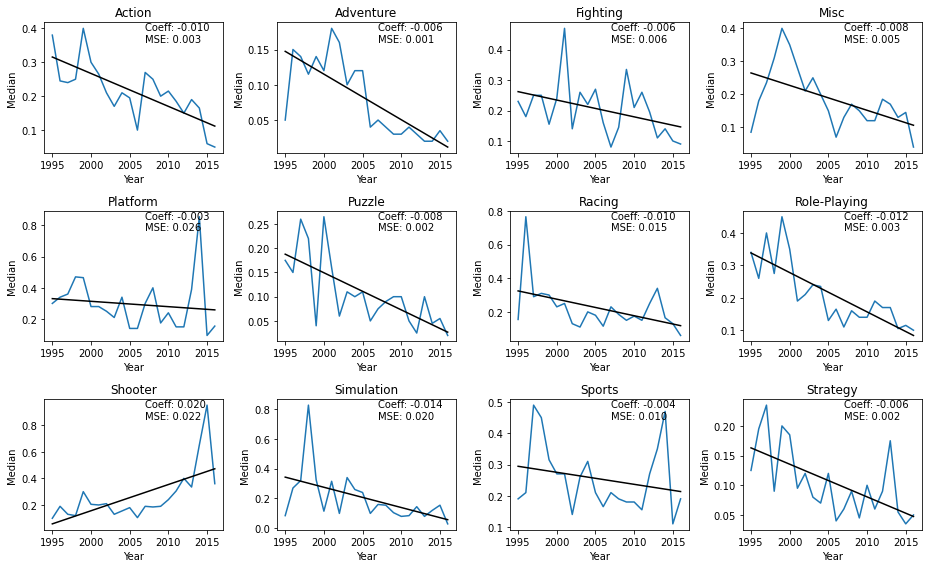

In [14]:
Med_Sales_by_Genre_and_Year = Med_Sales_by_Genre_and_Year.loc[Med_Sales_by_Genre_and_Year.index >= 1995]

[Regr_Coeff_After_95, Regr_MSE_After_95] = LinearRegressionPlot(Med_Sales_by_Genre_and_Year)

Even after excluding the years before 1995 all but Shooter games have shown a decline in sales. However, after excluding the years before 1995 the severity of the decline in all but the sports genre lessened. Of the declining genres Simulation, Role-Playing, Racing, and Action games have incurred the steepest decline in sales.

In [12]:
Regr_Res = pd.DataFrame({'Regression Coeff After 1991':RegrCoeff,
                                         'MSE After 1991':RegrMSE,
                                         'Regression Coeff After 1995':Regr_Coeff_After_95,
                                         'MSE After 1995':Regr_MSE_After_95},
                                        index = list(Med_Sales_by_Genre_and_Year.columns))
Column_Order = ['Regression Coeff After 1991','MSE After 1991','Regression Coeff After 1995',
                'MSE After 1995']

# Printing the linear regression results
Regr_Res[Column_Order].head(n=len(list(Med_Sales_by_Genre_and_Year.columns)))

,Regression Coeff After 1991,MSE After 1991,Regression Coeff After 1995,MSE After 1995
Action,-0.020282,0.106425,-0.009695,0.003197
Adventure,-0.018154,0.031658,-0.006460,0.001132
Fighting,-0.017986,0.068396,-0.005517,0.006490
Misc,-0.019853,0.181360,-0.007549,0.005385
Platform,-0.023383,0.095485,-0.003425,0.025815
Puzzle,-0.026802,0.041777,-0.007662,0.002454
Racing,-0.047101,0.595477,-0.009825,0.015206
Role-Playing,-0.014938,0.018042,-0.012120,0.003419
Shooter,0.003713,0.092050,0.019701,0.021505
Simulation,-0.031340,0.129551,-0.013569,0.019819


With the decline in sales for all but one genre of video games, it would be normal to want to see if the same decline can be seen in the global sales for all genres. By plotting the yearly median of all global sales, it is apparent there is an overall a decline in global sales.

Text(0, 0.5, 'Median Sales (in millions)')

<Figure size 1008x360 with 0 Axes>

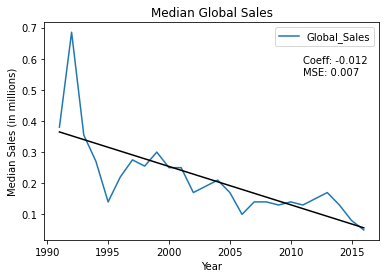

In [9]:
Med_Sales_by_Yr = pd.pivot_table(data,index=['Year_of_Release'], values=['Global_Sales'], aggfunc=np.median)

fig = plt.figure(figsize=(14,5))
Med_Sales_by_Yr.plot()

X_data = np.transpose(np.matrix(Med_Sales_by_Yr.index))
y_data = Med_Sales_by_Yr
regr_mod = linear_model.LinearRegression()
regr_mod.fit(X_data,y_data)

plt.plot(X_data,regr_mod.predict(X_data), color='black')

txt = 'Coeff: %.3f \nMSE: %.3f' % (regr_mod.coef_,np.mean((regr_mod.predict(X_data)-y_data)**2))

plt.text(2011,0.8*Med_Sales_by_Yr.max(),txt)

plt.title('Median Global Sales')
plt.xlabel('Year')
plt.ylabel('Median Sales (in millions)')

## 3.0 Analyzing sales by Platform
We will now be analysing the relationship between sales and the platform of gaming.

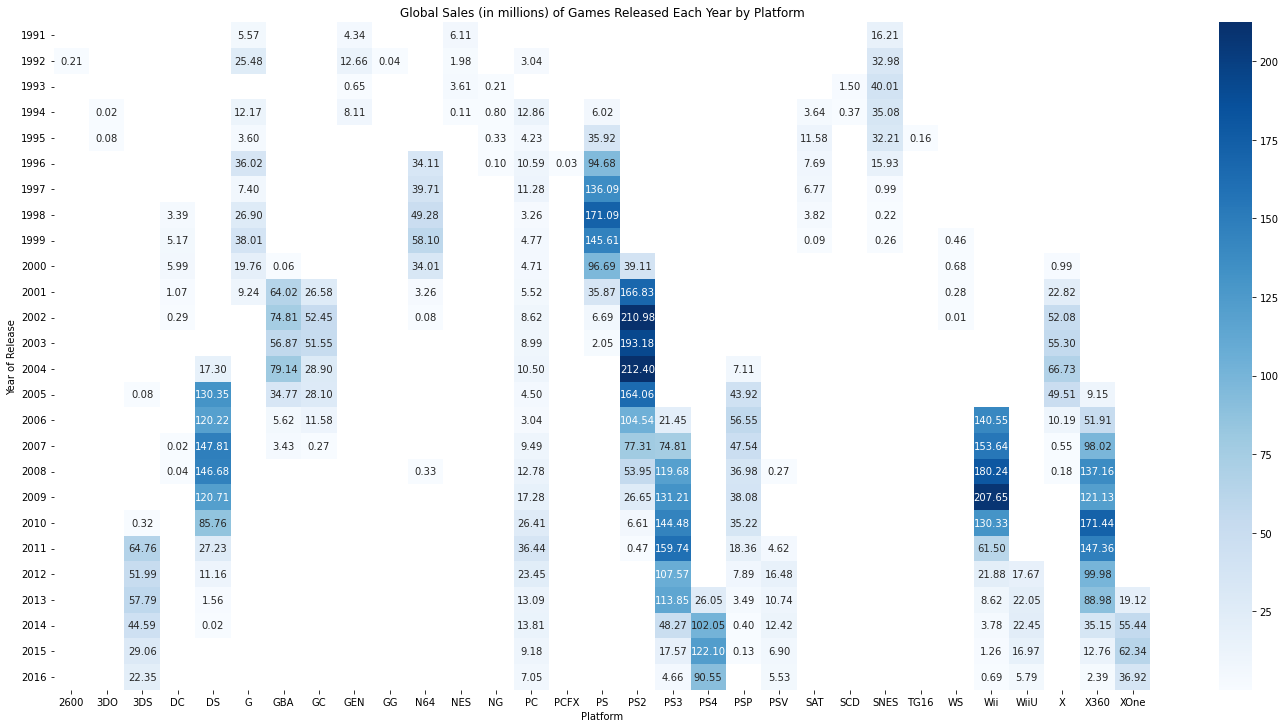

In [17]:
Sales_by_Platform_and_Year = pd.pivot_table(data, index=['Year_of_Release'], columns=['Platform'], values=['Global_Sales'], aggfunc=np.sum)
Sales_by_Platform_and_Year.columns = Sales_by_Platform_and_Year.columns.get_level_values(1)

# Plotting the heat map of global sales for games released each year by Platform
plt.figure(figsize=(20,10))
sns.heatmap(Sales_by_Platform_and_Year, annot = True, fmt = '.2f', cmap = 'Blues')
plt.tight_layout()
plt.ylabel('Year of Release')
plt.xlabel('Platform')
plt.title('Global Sales (in millions) of Games Released Each Year by Platform')
plt.show()

As we can see, unlike genres, where after they are introduced into the gaming market, they almost always have some amount of sales, even when it drops or decreases, platforms sales can sometimes reach zero.<br />
The reason for this is that while many games with a certain genres can be developed easily, platforms are hardware components which are much harder to manufacture. On top of that some platforms use technology of the era that they were created in, which means that as technology advances, they become obsolete. Any upgrades that are made to the platform hardware will usualy end up becoming a new platform altogether, ending the need for the previous platform.<br />
<br />
Another observation worth noting is that PC (Personal Computer) has always had a consistant amount of sales, unlike any other platforms.

#### Taking median global sales by platform:

In [22]:
# Pulling only the data from 1991 to 2016
data = data.loc[data['Year_of_Release'] >= 1991]

# Finding the median sales value by Platform and year
Med_Sales_by_Platform_and_Year = pd.pivot_table(data, index=['Year_of_Release'], columns=['Platform'], values=['Global_Sales'], aggfunc=np.median)
Med_Sales_by_Platform_and_Year.columns = Med_Sales_by_Platform_and_Year.columns.get_level_values(1)
Med_Sales_by_Platform_and_Year = Med_Sales_by_Platform_and_Year.replace(np.nan, 0)

Med_Sales_by_Platform_and_Year.head(10)

Platform,2600,3DO,3DS,DC,DS,G,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X,X360,XOne
Year_of_Release,,,,,,,,,,,,,,,,,,,,,
1991,0.00,0.00,0.0,0.000,0.0,0.380,0.00,0.0,4.340,0.00,...,0.000,0.00,0.310,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1992,0.21,0.00,0.0,0.000,0.0,2.190,0.00,0.0,1.855,0.04,...,0.000,0.00,0.460,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1993,0.00,0.00,0.0,0.000,0.0,0.000,0.00,0.0,0.070,0.00,...,0.000,1.50,0.455,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1994,0.00,0.02,0.0,0.000,0.0,3.910,0.00,0.0,0.200,0.00,...,0.090,0.06,0.360,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1995,0.00,0.04,0.0,0.000,0.0,0.470,0.00,0.0,0.000,0.00,...,0.120,0.00,0.275,0.08,0.00,0.0,0.0,0.00,0.0,0.0
1996,0.00,0.00,0.0,0.000,0.0,0.900,0.00,0.0,0.000,0.00,...,0.140,0.00,0.215,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1997,0.00,0.00,0.0,0.000,0.0,1.000,0.00,0.0,0.000,0.00,...,0.145,0.00,0.235,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1998,0.00,0.00,0.0,0.140,0.0,2.075,0.00,0.0,0.000,0.00,...,0.090,0.00,0.110,0.00,0.00,0.0,0.0,0.00,0.0,0.0
1999,0.00,0.00,0.0,0.275,0.0,0.770,0.00,0.0,0.000,0.00,...,0.090,0.00,0.260,0.00,0.23,0.0,0.0,0.00,0.0,0.0


## 4.0 Conclusion
With the exception of Shooter games the global sales of all other video game genres have been declining. This could be due to the increase in games being played on tablets and smart phones. First person shooter games are not easily played with touchscreen controls causing them to be unaffected by the increase in popularity of using tablets and smart phones as a gaming platform. It would be interesting to find a data set that had the global downloads of games for tablets and smart phones and compare it with this data set. If anyone has any interesting theories, please let me know. Also I am still new to programming in Python and am open to any suggestions about creating a cleaner program.
<br /><br />
From the above analysis, we can conclude that if a 